In [1]:
import pandas as pd
from extract_data import extract_data
import numpy as np
import umap
import sklearn
from scipy.optimize import linear_sum_assignment
from purity_check import purity_check
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from genSankey import genSankey
import chart_studio.plotly as py
import plotly

import plotly.graph_objs as go

In [2]:
df = pd.read_csv('num_data.csv')

In [3]:
for i in df.columns:
    if 'generalelection' in i:
        df = df.drop(i,1)

In [4]:
data_array = np.array(df)
data_array = np.delete(data_array,0,1)
data_array = np.delete(data_array,-1,1)

In [5]:
general = extract_data("data","data",1)

In [6]:
df['generalElectionVote'] = general['generalElectionVote']

In [7]:
data = df
#removing don't know's and no votes from the labels, label choice is who people voted in the general election
data['generalElectionVote'] = data['generalElectionVote'].fillna("Don't know") 

list_to_remove = []
for i in range(data.shape[0]):
    if data.loc[i,'generalElectionVote'] == "Don't know":
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] == "No - none":
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] == "Plaid Cymru":
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] == "Scottish National Party (SNP)":
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] ==    'I would/did not vote':
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] ==  'Other':
        list_to_remove.append(i)
   # elif data.loc[i,'generalElectionVote'] ==  'Brexit Party':
    #    list_to_remove.append(i)
    #elif data.loc[i,'generalElectionVote'] ==  'Green Party':
     #   list_to_remove.append(i)
   # elif data.loc[i,'generalElectionVote'] ==  'An independent candidate':
    #    list_to_remove.append(i)
    #elif data.loc[i,'generalElectionVote'] ==  'United Kingdom Independence Party (UKIP)':
     #   list_to_remove.append(i)
        
        
    
data = data.drop(list_to_remove,0)
data = data.reset_index(drop=True)
data_array = np.delete(data_array,list_to_remove,0)

In [8]:
labels = pd.DataFrame({'generalElectionVote':data['generalElectionVote']})
labels['Vote'] = labels['generalElectionVote'].cat.remove_unused_categories()

In [9]:
mapping = {item:i for i, item in enumerate(labels["Vote"].unique())}
labels["EnumLabl"] = labels["Vote"].apply(lambda x: mapping[x])

In [10]:

labels_array = np.array(labels['EnumLabl'],dtype=np.float64)

In [11]:
%%time
embedding = umap.UMAP(n_neighbors=27,n_components=2).fit_transform(data_array,y=labels_array)

Wall time: 44.3 s


In [12]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [17]:
c_map = ListedColormap(["royalblue","gold","red", "deepskyblue", "green","purple"])

Text(0.5, 1.0, 'Full Data set Embedded via UMAP using Labels')

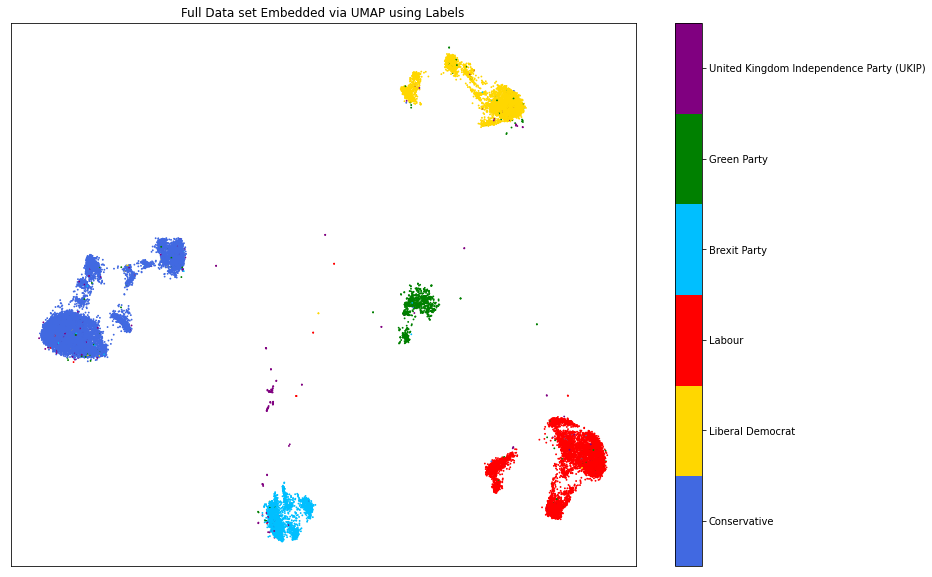

In [18]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(embedding[:,0],embedding[:,1], s=0.7, c=labels_array, cmap=c_map, alpha=1.0,)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(labels["Vote"].unique())
plt.title('Full Data set Embedded via UMAP using Labels and 27 nearest neighbors')

In [36]:
def f1_cluster_assignments_lists(optimal_cluster_assignments,stage=None):
    optimal_cluster_assignments_names = []
    optimal_cluster_assignments_number = []
    for i in range(optimal_cluster_assignments[0].shape[0]):
        name = data.loc[optimal_cluster_assignments[0][i],'generalElectionVote']
        cluster_number = optimal_cluster_assignments[1][i]
        
        if stage != None:
            print(name)
            name = name + "_stage_" + str(stage)
        optimal_cluster_assignments_names.append(name)
        optimal_cluster_assignments_number.append(cluster_number)
    return optimal_cluster_assignments_names, optimal_cluster_assignments_number

In [361]:
def kmeans_distance(cluster,data_compare,n_clusters):
    cost_matrix = np.zeros([data_compare.shape[0],n_clusters])
    for i in range(data_compare.shape[0]):
        point_costs = []
        for c in range(n_clusters):
            diss = np.linalg.norm(data_compare[i,:]-cluster[c,:])
            cost_matrix[i,c]=diss
    return cost_matrix

In [519]:
#Elbow method

cluster_numbers =[]
sum_of_squared_distances = []
for i in range(6,20):
    cluster_numbers.append(i)
    kmeans = KMeans(i, random_state=0)
    kmeans.fit_predict(embedding)
    sum_of_squared_distances.append(kmeans.inertia_)
   
    

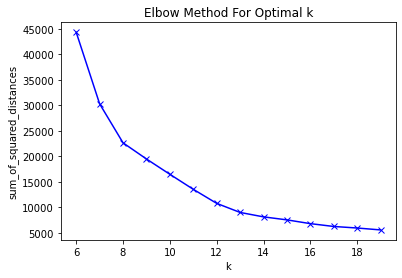

In [520]:
plt.plot(cluster_numbers, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [522]:
n_clusters = 8
#from elbow plot

In [550]:

kmeans = KMeans(n_clusters, random_state=0)
kmeans.fit_predict(embedding)
kmeans_cost = kmeans_distance(kmeans.cluster_centers_,embedding,n_clusters)
optimal_assignments = linear_sum_assignment(kmeans_cost)
cluster_assignments_names, cluster_assignments_number = f1_cluster_assignments_lists(optimal_assignments)
cluster_assignments = pd.DataFrame({'Party Vote':data['generalElectionVote']})
cluster_assignments['FirstAssignment'] = kmeans.labels_
for x in range(len(cluster_assignments_number)):
    cluster_assignments['FirstAssignment'] = cluster_assignments['FirstAssignment'].replace(int(cluster_assignments_number[x]),cluster_assignments_names[x])
cluster_assignments['FirstAssignment'] = cluster_assignments['FirstAssignment'].astype('category')
cluster_assignments['FirstAssignment'] = cluster_assignments['FirstAssignment'].cat.remove_unused_categories()
cluster_assignments['Party Vote'] = cluster_assignments['Party Vote'].cat.remove_unused_categories()
sum_of_squared_distances.append(kmeans.inertia_)
y_true = np.transpose(np.array(cluster_assignments['Party Vote']))
y_pred = np.transpose(np.array(cluster_assignments['FirstAssignment']))
f1 = sklearn.metrics.f1_score(y_pred,y_true,average='micro')
mean_purity = purity_check(kmeans.labels_,labels,n_clusters)

print('F1 score is:',f1)
print('purity is:', mean_purity)

F1 score is: 0.9980720946915351
purity is: 0.9985161605643278


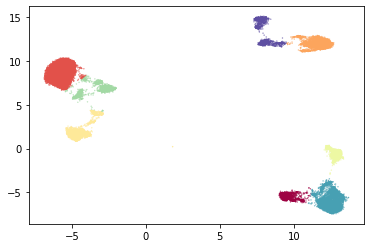

In [551]:
kmeans_labels = kmeans.labels_
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

In [552]:
def optimal_cluster_assignments_lists(optimal_cluster_assignments,stage=None):
    optimal_cluster_assignments_names = []
    optimal_cluster_assignments_number = []
    for i in range(optimal_cluster_assignments[0].shape[0]):
        name = data.loc[optimal_cluster_assignments[0][i],'generalElectionVote']
        cluster_number = optimal_cluster_assignments[1][i]
        name_count = 0 
        for x in range(len(optimal_cluster_assignments_names)):
                if name in optimal_cluster_assignments_names[x]:
                    name_count += 1
        if name_count != 0:
            name = name + str(name_count+1)
        if stage != None:
            print(name)
            name = name + "_stage_" + str(stage)
        optimal_cluster_assignments_names.append(name)
        optimal_cluster_assignments_number.append(cluster_number)
    return optimal_cluster_assignments_names, optimal_cluster_assignments_number

In [553]:
kmeans_cost = kmeans_distance(kmeans.cluster_centers_,embedding,n_clusters)
first_optimal_assignments = linear_sum_assignment(kmeans_cost)
first_cluster_assignments_names, first_cluster_assignments_number = optimal_cluster_assignments_lists(first_optimal_assignments)

In [554]:
print(first_cluster_assignments_number)
print(first_cluster_assignments_names)


[1, 4, 0, 5, 2, 7, 3, 6]
['Conservative', 'Labour', 'Labour2', 'Conservative2', 'Liberal Democrat', 'Liberal Democrat2', 'Conservative3', 'Labour3']


In [555]:

#making a data frame for the parties
cluster_assignments = pd.DataFrame({"Party Vote" : data.loc[:,'generalElectionVote'] })
cluster_assignments['First Assignment'] = kmeans.labels_


In [556]:
#replacing the numeric cluster assignment with the optimal name
for i in range(len(first_cluster_assignments_number)):
    cluster_assignments['First Assignment'] = cluster_assignments['First Assignment'].replace(int(first_cluster_assignments_number[i]),first_cluster_assignments_names[i])



In [557]:
kmeans.cluster_centers_ = np.delete(kmeans.cluster_centers_,[2,7],0) # deleting clusters

second_assignment = kmeans.predict(embedding)

In [558]:
cluster_assignments['Second Assignment'] = second_assignment

second_costs = kmeans_distance(kmeans.cluster_centers_,embedding,n_clusters-2)

second_optimal_assignments = linear_sum_assignment(second_costs)

second_cluster_assignments_names, second_cluster_assignments_number = optimal_cluster_assignments_lists(second_optimal_assignments)


for i in range(len(second_cluster_assignments_number)):
    cluster_assignments['Second Assignment'] = cluster_assignments['Second Assignment'].replace(int(second_cluster_assignments_number[i]),second_cluster_assignments_names[i])


In [559]:
print(second_cluster_assignments_number)
print(second_cluster_assignments_names)

[1, 3, 0, 4, 2, 5]
['Conservative', 'Labour', 'Labour2', 'Conservative2', 'Conservative3', 'Labour3']


In [560]:
cluster_assignments['Second Assignment'].unique()

array(['Conservative', 'Labour', 'Labour3', 'Conservative3',
       'Conservative2', 'Labour2'], dtype=object)

In [543]:
index_count = []

for i in range(cluster_assignments.shape[0]):
    index_count.append(i)

cluster_assignments['index'] = index_count

In [115]:
#figure = genSankey(cluster_assignments,cat_cols=['First Assignment','Second Assignment'],value_cols='index',title='Movement of voters after drop out')

#plotly.offline.plot(figure, validate=False)

'temp-plot.html'

In [561]:
ammount_change = 0 
for x in cluster_assignments['First Assignment']:
    if 'Liberal' in x:
        ammount_change +=1

In [562]:
ammount_change

4789

In [563]:
(cluster_assignments['Second Assignment'].value_counts() - cluster_assignments['First Assignment'].value_counts())/ammount_change

Conservative         0.000000
Conservative2        0.371059
Conservative3        0.000000
Labour               0.628941
Labour2              0.000000
Labour3              0.000000
Liberal Democrat          NaN
Liberal Democrat2         NaN
dtype: float64